<a href="https://colab.research.google.com/github/sinharudraneel/genre-classification-GTZAN-CNN/blob/main/mfcc_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import librosa
import librosa.display
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_path = '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification'
print(list(os.listdir(f'{input_path}/genres_original/')))
JSON_PATH = 'features.json'

['reggae', 'disco', 'pop', 'classical', 'rock', 'jazz', 'hiphop', 'metal', 'blues', 'country']


In [4]:
DATASET_PATH = '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original'
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
JSON_PATH = 'features_20.json'

def extract_mfcc(dataset_path, json_path, num_mfcc=40, num_fft=2048, hop_length=512, num_seg=5):

    data_dict = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_seg)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    print(num_samples_per_segment)
    print(expected_num_mfcc_vectors_per_segment)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split("/")
            semantic_label = dirpath_components[-1]
            data_dict["mapping"].append(semantic_label)

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                print(file_path)
                if file_path == '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/jazz/jazz.00054.wav':
                    continue
                __signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                #librosa.feature.melspectrogram(y=__signal, sr=sr, n_fft=num_fft, hop_length=hop_length, )


                for s in range(num_seg):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    mfcc = librosa.feature.mfcc(y=__signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_mfcc=num_mfcc,
                                                n_fft=num_fft,
                                                hop_length = hop_length)
                    mfcc = mfcc.T

                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data_dict["mfcc"].append(mfcc.tolist())
                        data_dict["labels"].append(i-1)

    with open (json_path, "w") as fp:
        json.dump(data_dict, fp, indent=4)


extract_mfcc(DATASET_PATH, JSON_PATH, num_mfcc=20, num_seg = 5)


132300
259
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00002.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00003.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00000.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00001.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00008.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00007.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00010.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00015.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classific

In [ ]:
INPUT_DATA_PATH = '/content/features_20.json'

def load_data_from_json(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

        inputs = np.array(data["mfcc"])
        targets = np.array(data["labels"])

        return inputs, targets


In [ ]:
#INPUT_DATA_PATH_40 = '../internship/features_40.json'
#z, w = load_data_from_json(INPUT_DATA_PATH)

#print(z.shape)

def split_dataset(test_split, validation_split):
    z, w = load_data_from_json(INPUT_DATA_PATH)
    x_train, x_test, y_train, y_test = train_test_split(z, w, test_size=test_split)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_split)

    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]

    return x_train, x_test, x_validation, y_train, y_test, y_validation



In [ ]:
#Building the model

x_train, x_test, x_validation, y_train, y_test, y_validation = split_dataset(0.2, 0.25)

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print(input_shape)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(10, activation='softmax'))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=80, epochs=60)



(259, 20, 1)
Epoch 1/60
38/38 [==============================] - 6s 38ms/step - loss: 2.3235 - accuracy: 0.2775 - val_loss: 7.1197 - val_accuracy: 0.1652
Epoch 2/60
38/38 [==============================] - 1s 30ms/step - loss: 1.6642 - accuracy: 0.4497 - val_loss: 3.4846 - val_accuracy: 0.2883
Epoch 3/60
38/38 [==============================] - 1s 30ms/step - loss: 1.4080 - accuracy: 0.5326 - val_loss: 2.2505 - val_accuracy: 0.3734
Epoch 4/60
38/38 [==============================] - 1s 32ms/step - loss: 1.2332 - accuracy: 0.5930 - val_loss: 1.3739 - val_accuracy: 0.5295
Epoch 5/60
38/38 [==============================] - 1s 32ms/step - loss: 1.1260 - accuracy: 0.6270 - val_loss: 1.1134 - val_accuracy: 0.6356
Epoch 6/60
38/38 [==============================] - 1s 32ms/step - loss: 1.0164 - accuracy: 0.6618 - val_loss: 1.1191 - val_accuracy: 0.6296
Epoch 7/60
38/38 [==============================] - 1s 32ms/step - loss: 0.9216 - accuracy: 0.6998 - val_loss: 1.0395 - val_accuracy: 0.6587


In [ ]:
test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy is: {}".format(test_accuracy))

32/32 [==============================] - 0s 4ms/step - loss: 0.8819 - accuracy: 0.7958
Test Accuracy is: 0.7957957983016968


In [ ]:
model.save('/content/drive/MyDrive/Internship/colab_model_96-96_84-08_83-78.keras')

In [ ]:
def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
predicting_model = tf.keras.models.load_model('/content/drive/MyDrive/Internship/colab_model_96-96_84-08_83-78.keras')
z, w = load_data_from_json(INPUT_DATA_PATH)
predict(predicting_model, z[545], w[545])

1/1 [==============================] - 0s 119ms/step
Target: 1, Predicted label: [1]


In [ ]:
score = predicting_model.evaluate(z, w, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.32448863983154297
Test accuracy: 0.9337071776390076


In [ ]:
import random
r = random.randint(0,4992)
print(z.shape)
predict(predicting_model, z[r], w[r])

(4993, 259, 20)
1/1 [==============================] - 0s 101ms/step
Target: 9, Predicted label: [4]


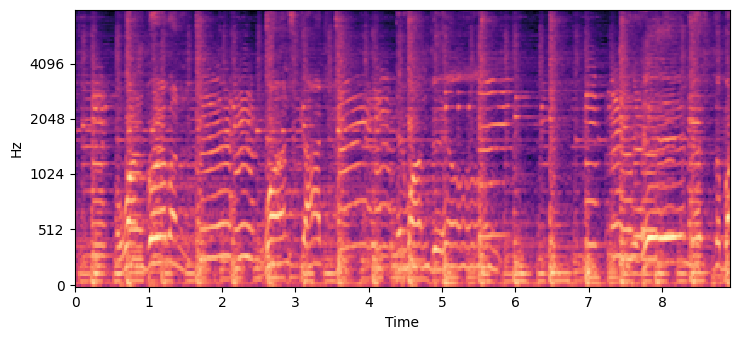

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

hl = 512 # number of samples per time-step in spectrogram
hi = 128 # Height of image
wi = 384 # Width of image

# Loading demo track
y, sr = librosa.load('/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/blues/blues.00000.wav')
window = y[0:wi*hl]

S = librosa.feature.melspectrogram(y=window, sr=sr, n_mels=hi, fmax=8000,
hop_length=hl)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)

In [ ]:
audio, sample_rate = librosa.load('/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/blues/blues.00000.wav')
frame_size = 2048
hop_size = 512
stft_audio = librosa.stft(audio, n_fft=frame_size, hop_length=hop_size)
stft_audio.shape

y_audio = np.abs(stft_audio)
y_audio.shape
DB = librosa.amplitude_to_db(y_audio, ref=np.max)
print(DB.shape)
librosa.display.specshow(DB, sr=sample_rate, hop_length=hop_size, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.savefig('blues.00000.png')

NameError: ignored

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original'
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
JSON_PATH = '/content/drive/MyDrive/Internship/stft.json'

def extract_stft(dataset_path, num_fft=2048, hop_length=512, num_seg=5):

    data_dict = {
        "mapping": [],
        "stft": [],
        "labels": []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_seg)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split("/")
            semantic_label = dirpath_components[-1]
            data_dict["mapping"].append(semantic_label)

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                print(file_path)
                if file_path == '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/jazz/jazz.00054.wav' or file_path == '/content/drive/MyDrive/internship/GTZAN-dataset-music-genre-classification/genres_original/classical/classical.00094.wav':
                    continue
                __signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                #librosa.feature.melspectrogram(y=__signal, sr=sr, n_fft=num_fft, hop_length=hop_length, )


                for s in range(num_seg):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    stft = librosa.stft(y=__signal[start_sample:finish_sample],
                                                n_fft=num_fft,
                                                hop_length = hop_length)
                    stft = np.abs(stft)
                    DB = librosa.amplitude_to_db(stft, ref=np.max)
                    librosa.display.specshow(DB, sr=SAMPLE_RATE, hop_length=hop_length, x_axis='time', y_axis='log')
                    plt.colorbar(format='%+2.0f dB')
                    save_path = '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/images_stft/'+ semantic_label + '/' + f[:-3] + 'png'
                    plt.savefig(save_path)


if __name__ == "__main__":
    extract_stft(DATASET_PATH, num_seg = 5)

In [ ]:
JSON_PATH = '/content/drive/MyDrive/Internship/stft.json'
DATASET_PATH = '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original'
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def extract_stft(dataset_path, json_path, num_fft=2048, hop_length=512, num_seg=5):

    data_dict = {
        "mapping": [],
        "stft": [],
        "labels": []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_seg)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split("/")
            semantic_label = dirpath_components[-1]
            data_dict["mapping"].append(semantic_label)

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                print(file_path)
                if file_path == '/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/jazz/jazz.00054.wav' or file_path == '/content/drive/MyDrive/internship/GTZAN-dataset-music-genre-classification/genres_original/classical/classical.00094.wav':
                    continue
                __signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                #librosa.feature.melspectrogram(y=__signal, sr=sr, n_fft=num_fft, hop_length=hop_length, )


                for s in range(num_seg):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    stft = librosa.stft(y=__signal[start_sample:finish_sample],
                                                n_fft=num_fft,
                                                hop_length = hop_length)
                    stft = np.abs(stft) ** 2
                    log_stft = librosa.power_to_db(stft)
                    #print(log_stft.shape)


                    if len(log_stft[1]) == expected_num_mfcc_vectors_per_segment:
                            data_dict["stft"].append(log_stft.tolist())
                            data_dict["labels"].append(i-1)

    with open (json_path, "w") as fp:
        json.dump(data_dict, fp, indent=4)


if __name__ == "__main__":
    extract_stft(DATASET_PATH, JSON_PATH, num_seg = 5)

Exception ignored in: <function _xla_gc_callback at 0x7c84c4587b50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00012.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00009.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00005.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00004.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00016.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00023.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00024.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00018.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genre

Exception ignored in: <function _xla_gc_callback at 0x7c84c4587b50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00054.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00046.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00048.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00047.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00044.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00043.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00052.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genres_original/reggae/reggae.00050.wav
/content/drive/MyDrive/Internship/GTZAN-dataset-music-genre-classification/genre

KeyboardInterrupt: ignored